In [1]:
using Plots
using LinearAlgebra
using Random
using JLD
using StatsPlots
using ProgressMeter
include("/home/javier/Desktop/alpcahus/alpcahus.jl")
include("/home/javier/Desktop/alpcahus/cluster.jl")
include("/home/javier/Desktop/alpcahus/otherMethods.jl")
include("/home/javier/Desktop/alpcahus/adssc.jl")

lsr (generic function with 1 method)

In [2]:
# All matrices have 1020 genes (rows) and 5000 cell samples (columns)
# Split evenly between subspaces and train/test data
Y1test = load("human.jld", "test")
Y2test = load("mouse.jld", "test")
Y1train = load("human.jld", "train")
Y2train = load("mouse.jld", "train")
K = 2

2

In [3]:
Utrue = []
push!(Utrue,fastALPCAH(Y1test[:,1:1000],21; varfloor=1e-9, alpcahIter= 1000, fastCompute=false))
push!(Utrue,fastALPCAH(Y2test[:,1:1000],21; varfloor=1e-9, alpcahIter= 1000, fastCompute=false))
nothing;

In [4]:
methodsList = ["Noisy Oracle" "EKSS" "ALPCAHUS" "EKSS (B=1)" "ALPCAHUS (B=1)" "ADSSC" "TSC" "K-means"]
num_methods = length(methodsList)
num_trials = 100; ntest = 100 

100

In [5]:
test_errors = zeros(num_methods,2,num_trials)
p = Progress(num_trials; dt=1)
for trial=1:num_trials
    shuffleIndex1 = shuffle(1:size(Y1test)[2])[1:ntest]
    shuffleIndex2 = shuffle(1:size(Y2test)[2])[1:ntest]
    shuffleIndex3 = shuffle(1:size(Y1test)[2])[1:ntest]
    shuffleIndex4 = shuffle(1:size(Y2test)[2])[1:ntest]
    
    
    test1 = @view Y1test[:,shuffleIndex1]
    test2 = @view Y2test[:,shuffleIndex2]
    train1 = @view Y1train[:,shuffleIndex3]
    train2 = @view Y2train[:,shuffleIndex4]
    Ytest = hcat(test1,test2)
    Ytrain = hcat(train1,train2)
    C = vcat(1*ones(Int, ntest), 2*ones(Int, ntest))

    # METHODS
    # Noisy Oracle
    U = []
    for k=1:K
        push!(U,fastALPCAH(Ytest[:,C .== k], 21; varfloor=1e-9, alpcahIter= 1000, fastCompute=false))
    end
    C_oracle = clusterAssignment(Ytest, U, K);
    oracleError = clusterError(C,C_oracle)
    # ekss trial
    C_ekss = ALPCAHUS(Ytest,K,[1;1]; B=128, q=50, T=3, subspaceMethod=:pca, finalStep=false)
    ekssError = clusterError(C,C_ekss)
    # alpcahus trail
    C_alpcahus = ALPCAHUS(Ytest,K,[21;21]; B=128, q=50, T=3, alpcahIter=10, subspaceMethod=:alpcah, finalStep=true) 
    alpcahusError = clusterError(C,C_alpcahus)
    # ekss smart init trial
    C_kss = ALPCAHUS(Ytest, K, [1;1]; B=1, q=50, T=100, subspaceMethod=:pca, finalStep=false, spectralStart=true)
    kssError = clusterError(C, C_kss)
    # alpcahus smart init trail
    C_alpcah = ALPCAHUS(Ytest,K, [21;21]; B=1, q=50, T=100, alpcahIter=10, subspaceMethod=:alpcah, finalStep=true, spectralStart=true) 
    alpcahError = clusterError(C, C_alpcah)
    # adssc
    A = adssc(Ytest, 100, 1)
    A = 0.5*(A + A')
    C_adssc = spectralClustering(Matrix(A),K)
    adsscError = clusterError(C,C_adssc)
    # tsc
    A = tsc(Ytest, 10)
    A = 0.5*(A + A')
    C_tsc = spectralClustering(Matrix(A),K)
    tscError = clusterError(C,C_tsc)
    # kmeans
    C_kmeans = kmeans(Elkan(), Ytest, 2; k_init="k-means++").assignments
    kmeansError = clusterError(C,C_kmeans)

    subspace_ekss = 0; subspace_alpcahus = 0; subspace_kss = 0; subspace_alpcah = 0; subspace_adssc = 0; subspace_tsc = 0;subspace_kmeans = 0; 
    for k = 1:K
        U = fastALPCAH(Ytest[:,C_ekss .== k],21; alpcahIter= 100)
        subspace_ekss = norm(Ytrain[:,C .== k] - U*(U'*Ytrain[:,C .== k])) / norm(Ytrain[:,C .== k])
        U = fastALPCAH(Ytest[:,C_alpcahus .== k],21; alpcahIter= 100)
        subspace_alpcahus = norm(Ytrain[:,C .== k] - U*(U'*Ytrain[:,C .== k])) / norm(Ytrain[:,C .== k])
        U = fastALPCAH(Ytest[:,C_kss .== k],21; alpcahIter= 100)
        subspace_kss = norm(Ytrain[:,C .== k] - U*(U'*Ytrain[:,C .== k])) / norm(Ytrain[:,C .== k])
        U = fastALPCAH(Ytest[:,C_alpcah .== k],21; alpcahIter= 100)
        subspace_alpcah = norm(Ytrain[:,C .== k] - U*(U'*Ytrain[:,C .== k])) / norm(Ytrain[:,C .== k])
        U = fastALPCAH(Ytest[:,C_adssc .== k],21; alpcahIter= 100)
        subspace_adssc = norm(Ytrain[:,C .== k] - U*(U'*Ytrain[:,C .== k])) / norm(Ytrain[:,C .== k])
        U = fastALPCAH(Ytest[:,C_tsc .== k],21; alpcahIter= 100)
        subspace_tsc = norm(Ytrain[:,C .== k] - U*(U'*Ytrain[:,C .== k])) / norm(Ytrain[:,C .== k])
        
        U = fastALPCAH(Ytest[:,C_kmeans .== k],21; alpcahIter= 100)
        subspace_kmeans = norm(Ytrain[:,C .== k] - U*(U'*Ytrain[:,C .== k])) / norm(Ytrain[:,C .== k])
        
        # U = fastALPCAH(Ytest[:,C_ekss .== k],21; alpcahIter= 100)
        # subspace_ekss += norm(Utrue[k]*Utrue[k]' - U*U')/norm(Utrue[k]*Utrue[k]')
        # U = fastALPCAH(Ytest[:,C_alpcahus .== k],21; alpcahIter= 100)
        # subspace_alpcahus += norm(Utrue[k]*Utrue[k]' - U*U')/norm(Utrue[k]*Utrue[k]')
        # U = fastALPCAH(Ytest[:,C_kss .== k],21; alpcahIter= 100)
        # subspace_kss += norm(Utrue[k]*Utrue[k]' - U*U')/norm(Utrue[k]*Utrue[k]')
        # U = fastALPCAH(Ytest[:,C_alpcah .== k],21; alpcahIter= 100)
        # subspace_alpcah += norm(Utrue[k]*Utrue[k]' - U*U')/norm(Utrue[k]*Utrue[k]')
        # U = fastALPCAH(Ytest[:,C_adssc .== k],21; alpcahIter= 100)
        # subspace_adssc += norm(Utrue[k]*Utrue[k]' - U*U')/norm(Utrue[k]*Utrue[k]')
        # U = fastALPCAH(Ytest[:,C_tsc .== k],21; alpcahIter= 100)
        # subspace_tsc += norm(Utrue[k]*Utrue[k]' - U*U')/norm(Utrue[k]*Utrue[k]')
        
        # U = fastALPCAH(Ytest[:,C_kmeans .== k],21; alpcahIter= 100)
        # subspace_kmeans += norm(Utrue[k]*Utrue[k]' - U*U')/norm(Utrue[k]*Utrue[k]')

        # U = fastPCA(Ytest[:,C_ekss .== k],21)
        # subspace_ekss += norm(Utrue[k]*Utrue[k]' - U*U')/norm(Utrue[k]*Utrue[k]')
        
        # U = fastPCA(Ytest[:,C_alpcahus .== k],21)
        # subspace_alpcahus += norm(Utrue[k]*Utrue[k]' - U*U')/norm(Utrue[k]*Utrue[k]')
        # U = fastPCA(Ytest[:,C_kss .== k],21)
        # subspace_kss += norm(Utrue[k]*Utrue[k]' - U*U')/norm(Utrue[k]*Utrue[k]')
        # U = fastPCA(Ytest[:,C_alpcah .== k],21)
        # subspace_alpcah += norm(Utrue[k]*Utrue[k]' - U*U')/norm(Utrue[k]*Utrue[k]')
        # U = fastPCA(Ytest[:,C_adssc .== k],21)
        # subspace_adssc += norm(Utrue[k]*Utrue[k]' - U*U')/norm(Utrue[k]*Utrue[k]')
        # U = fastPCA(Ytest[:,C_tsc .== k],21)
        # subspace_tsc += norm(Utrue[k]*Utrue[k]' - U*U')/norm(Utrue[k]*Utrue[k]')
        # U = fastPCA(Ytest[:,C_kmeans .== k],21)
        # subspace_kmeans += norm(Utrue[k]*Utrue[k]' - U*U')/norm(Utrue[k]*Utrue[k]')
    end

    # save results
    test_errors[1,1,trial] = oracleError
    test_errors[2,1,trial] = ekssError
    test_errors[3,1,trial] = alpcahusError
    test_errors[4,1,trial] = kssError
    test_errors[5,1,trial] = alpcahError
    test_errors[6,1,trial] = adsscError
    test_errors[7,1,trial] = tscError
    test_errors[8,1,trial] = kmeansError

    test_errors[1,2,trial] = -100 # null value to make sure this isn't plotted
    test_errors[2,2,trial] = 0.5*subspace_ekss
    test_errors[3,2,trial] = 0.5*subspace_alpcahus
    test_errors[4,2,trial] = 0.5*subspace_kss
    test_errors[5,2,trial] = 0.5*subspace_alpcah
    test_errors[6,2,trial] = 0.5*subspace_adssc
    test_errors[7,2,trial] = 0.5*subspace_tsc
    test_errors[8,2,trial] = 0.5*subspace_kmeans
    
    next!(p)
end
finish!(p)

Progress: 100%|█████████████████████████████████████████| Time: 0:19:31


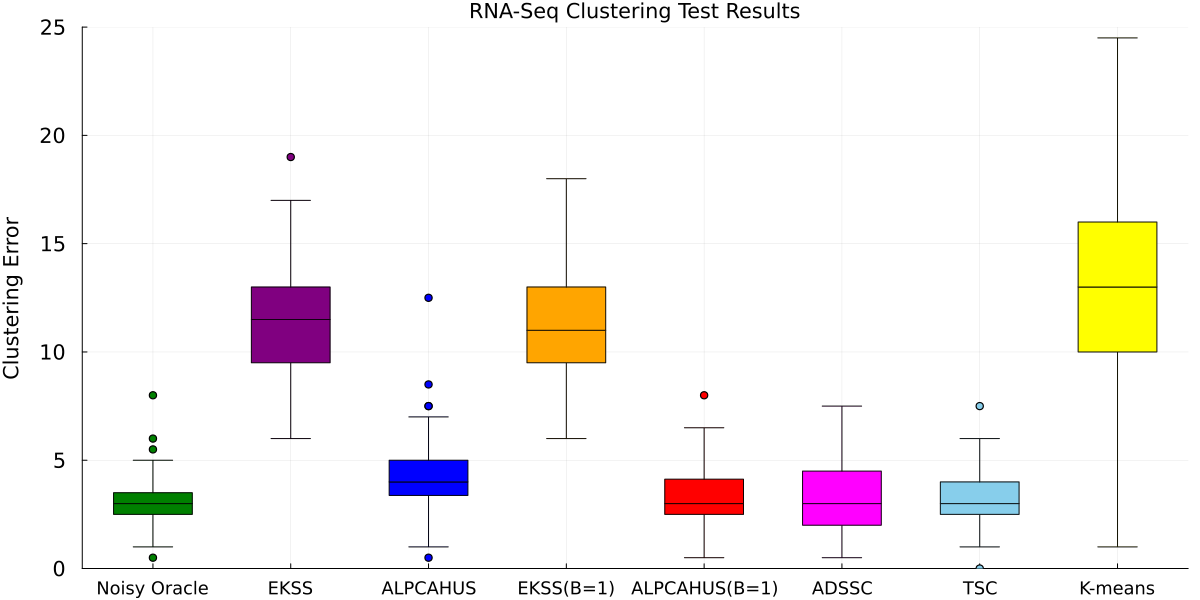

In [6]:
boxplots = []
titles = ["RNA-Seq Clustering Test Results"]
methodsList = ["Noisy Oracle" "EKSS" "ALPCAHUS" "EKSS(B=1)" "ALPCAHUS(B=1)" "ADSSC" "TSC" "K-means"]
#p = plot(size=(300,300))
p = boxplot(methodsList, test_errors[:,1,:]', leg = false,title=titles[1],color=[:green :purple :blue :orange :red :magenta :skyblue :yellow],ylabel="Clustering Error")
push!(boxplots,p)  

using Plots.PlotMeasures
# size=(2100,300)
plot_boxes = plot(boxplots..., size=(1200,600),
                    left_margin = 5mm,
                    xtickfont=font(12), 
                    ytickfont=font(14), 
                    guidefont=font(14), 
                    legendfont=font(14),
                    ylim = (0,25))
#savefig("clustering_results.pdf")

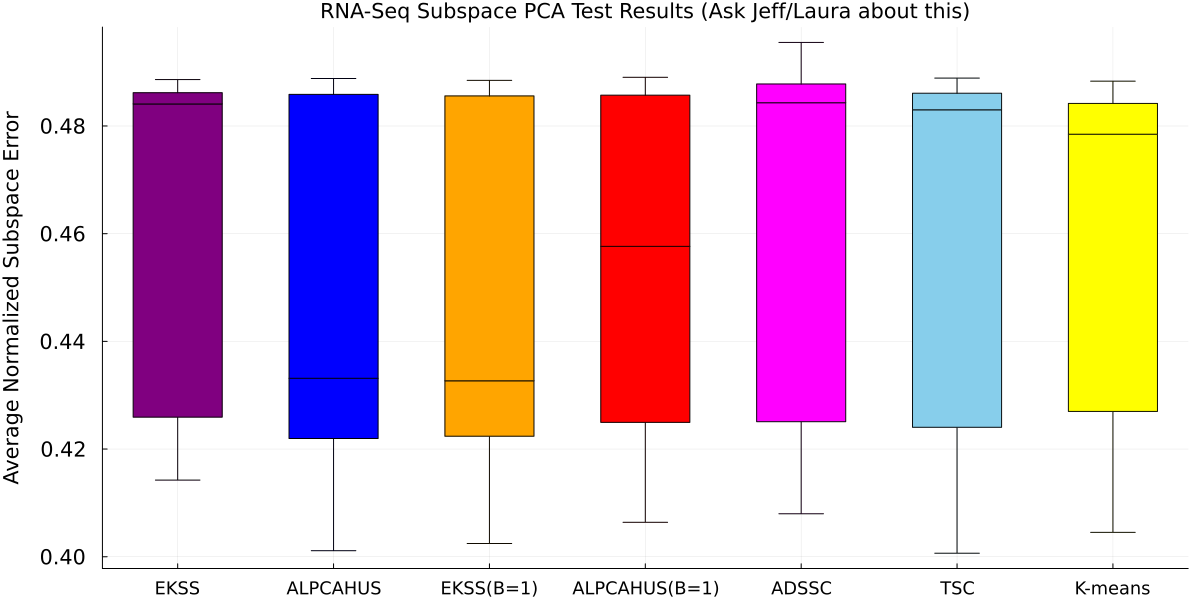

In [9]:
boxplots = []
titles = ["RNA-Seq Subspace PCA Test Results (Ask Jeff/Laura about this)"]
methodsList = ["EKSS" "ALPCAHUS" "EKSS(B=1)" "ALPCAHUS(B=1)" "ADSSC" "TSC" "K-means"]

#p = plot(size=(300,300))
p = boxplot(methodsList, test_errors[2:end,2,:]', leg = false,title=titles[1],color=[:purple :blue :orange :red :magenta :skyblue :yellow],ylabel="Average Normalized Subspace Error")
push!(boxplots,p)  

using Plots.PlotMeasures
# size=(2100,300)
plot_boxes = plot(boxplots..., size=(1200,600),
                    left_margin = 5mm,
                    xtickfont=font(12), 
                    ytickfont=font(14), 
                    guidefont=font(14), 
                    legendfont=font(14),
                    )
#savefig("results_subspaces_kylemetric.pdf")